# Practical Machine Learning and Deep learning

# Lesson 4: Many-to-many NLP task.



## About Many-to-Many Sequence in NLP

In natural language processing (NLP), many-to-many sequence models are crucial for tasks where the input and output sequences are both variable in length. One such task is Part-of-Speech (POS) tagging.

What is POS Tagging?
POS tagging involves labeling each word in a sentence with its corresponding part of speech (such as noun, verb, adjective, etc.). For instance, in the sentence "The quick brown fox jumps over the lazy dog," the goal is to assign tags like:

*   "tensorflow" -> noun
*   "is" -> verb
*   "very" -> adverb
*   "easy" -> adjective


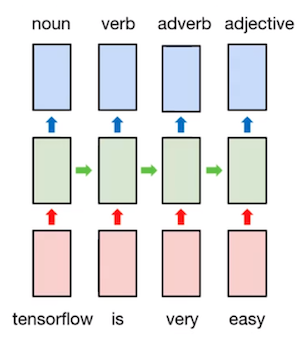


So let's start with importing the required libraries

In [ ]:
import pandas as pd
import torch
import warnings

warnings.filterwarnings('ignore')

## Data reading and preprocessing

The steps that we have followed in previous lessons would be followed here as well. Let's also see how our training and test data look like.

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
train.head()

In [ ]:
test.head()

First, let's divide dataset on train and validation. And split the dataframe according to random split.

---
### EXCERCISE 1: Split the Data


You will import `train_test_split` and set the validation ratio to 20%. It will create a range of `sentence_id` values from the `train` DataFrame. Using `train_test_split`, it will split these values into training (80%) and validation (20%) subsets. The resulting indices will be assigned to `train_split` and `val_split` for further use.

---

In [ ]:
from sklearn.model_selection import train_test_split
VALIDATION_RATIO = 0.2
train_split, val_split = train_test_split(range(train['sentence_id'].max()), test_size=VALIDATION_RATIO, random_state=420)

And then split the original dataframe by ids that we splitted.

In [ ]:
train_dataframe = train[train['sentence_id'].isin(train_split)]
val_dataframe = train[train['sentence_id'].isin(val_split)]

In [ ]:
pos_tags = ['ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'NOUN', 'NUM', 'PRT', 'PRON', 'VERB', '.', 'X']
cat2idx = {tag: i for i, tag in enumerate(pos_tags)}
idx2cat = {v: k for k, v in cat2idx.items()}

UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

# Define a list of POS tags (part-of-speech tags)
pos_tags = ['ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'NOUN', 'NUM', 'PRT', 'PRON', 'VERB', '.', 'X']

# Create a dictionary to map each POS tag to a unique index
cat2idx = {tag: i for i, tag in enumerate(pos_tags)}

# Create a reverse dictionary to map indices back to POS tags
idx2cat = {v: k for k, v in cat2idx.items()}

# Define indices for special symbols
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3

# Define a list of special symbols
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

# Example of how the above created dictionaries work:
# cat2idx['ADJ'] will be 0
# idx2cat[0] will be 'ADJ'
# UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX represent special tokens for unknown words, padding, beginning of sequence, and end of sequence respectively.


For working with datasets more efficiently, let's create separate classes for datasets. For this we will define the necessary functions.

---
### EXCERCISE 2: Create operations for POS Tagging Dataset

1. Preprocessing

  *   Handling Missing Values:
    - Find indices (null_rows) where 'entity' column is null and fill them with empty strings ('').

    - If 'tag' column exists, fill missing values with 'X' and update corresponding rows in null_rows to 'X'.

  *   Lowercasing:
    - Convert all values in 'entity' column to lowercase.

  *   Extracting Sentences and Tags:
    - Retrieve unique sentence IDs from 'sentence_id' column and fetch corresponding 'entity' values as sentences.
    - If 'tag' column exist, retrieve tags similarly using _get_labels() and store them in tags.

2. Postprocessing (_postprocess):

  *   Iterate through sentences and apply the vocabulary (vocab) to each sentence, converting it into numerical indices.

3. Creating Vocabulary (_create_vocab):

  *   Use build_vocab_from_iterator to create a vocabulary (vocab) from sentences, considering special symbols (special_symbols). Set the default index to UNK_IDX.

4. Fetching Sentences (_get_sentence):

  *   Retrieve sentences by index from the dataframe based on 'sentence_id' and return them as a list.

5. Fetching Labels (_get_labels):

  *   Retrieve tags by index from the dataframe based on 'sentence_id', convert them using cat2idx, and return them as a list.

6. Getting Data (`__getitem__`):

  *   Return a tuple containing sentences and tags (if 'tag' column exists) at index. If not, return just sentences.

7. Length of Dataset (`__len__`):

  *   Return the length of sentences, indicating the number of samples in the dataset.


---

In [ ]:
import torch
torch.manual_seed(420)
from torchtext.vocab import build_vocab_from_iterator


class PosTaggingDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe: pd.DataFrame, vocab = None, max_size=100):
        self.dataframe = dataframe
        self._preprocess()
        self.vocab = vocab or self._create_vocab()
        self._postprocess()

    def _preprocess(self):
        # fill missing values in entities
        null_rows = self.dataframe[self.dataframe['entity'].isnull()].index
        self.dataframe['entity'] = self.dataframe['entity'].fillna('')

        # Fill missing tag to `other` - `X`
        if 'tag' in self.dataframe.columns:
            self.dataframe['tag'] = self.dataframe['tag'].fillna('X')
            for rows in null_rows:
                self.dataframe.at[rows, 'tag'] = 'X'

        self.dataframe['entity'] = self.dataframe['entity'].apply(str.lower)
        # Clean entities column
        self.sentences = [self._get_sentence(idx) for idx in list(self.dataframe['sentence_id'].unique())]
        if 'tag' in self.dataframe.columns:
            self.tags = [self._get_labels(idx) for idx in list(self.dataframe['sentence_id'].unique())]

    def _postprocess(self):
        for i, sentence in enumerate(self.sentences):
            self.sentences[i] = self.vocab(sentence)

    def _create_vocab(self):
        # creates vocabulary that is used for encoding
        # the sequence of tokens (splitted sentence)
        vocab = build_vocab_from_iterator(self.sentences,
                                          specials=special_symbols)
        vocab.set_default_index(UNK_IDX)
        return vocab

    def _get_sentence(self, index: int) -> list:
        # retrieves sentence from dataset by index
        sent = list(self.dataframe.loc[self.dataframe['sentence_id'] == index]['entity'])
        return sent

    def _get_labels(self, index: int) -> list:
        # retrieves tags from dataset by index
        tags = list(self.dataframe.loc[self.dataframe['sentence_id'] == index]['tag'])
        tags = [cat2idx[tag] for tag in tags]
        return tags

    def __getitem__(self, index) -> tuple[list, list]:
        if 'tag' in self.dataframe.columns:
            return (self.sentences[index], self.tags[index])
        else:
            return self.sentences[index]\

    def __len__(self) -> int:
        return len(self.sentences)

In [ ]:
train_dataset = PosTaggingDataset(train_dataframe)
val_dataset = PosTaggingDataset(val_dataframe, vocab=train_dataset.vocab)

And now we are able to create dataloader faster, because we created torch datasets


We will set up a data processing pipeline for training and evaluating a neural network model for POS tagging.

### About the parameters

We will first define the batch size (batch_size = 128) and the maximum sequence length (max_size = 50) for the input data. The device is set to either GPU (cuda) if available, or CPU otherwise, ensuring that computations are performed on the most suitable hardware.


---
### EXCERCISE 3: Create Collate Batch function and Data Loaders


### Collate batch
`pad_sequence` will be used to pad sequences (`sentences_batch` and `postags_batch`) to the maximum length in the batch (`max_size`). Padding values will be 1 for sequences (`sentences_batch`) and `cat2idx['X']` (assumed mapping for padding value in tags) for tags (`postags_batch`).
`torch.unsqueeze` will be used to add a dimension to `postags_batch`, typically for compatibility with model inputs.

### Data Loaders
`DataLoader` instances (`train_dataloader` and `val_dataloader`) will be created for training (`train_dataset`) and validation (`val_dataset`) datasets.


---

In [ ]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import numpy as np

batch_size = 128
max_size = 50

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def collate_batch(batch: list):
    # Collate list of samples into tensor batch
    # As an input we have list of pair from dataset:
    # [([ent1, ent2, ...], [tag1, tag2, ...]), ([ent1, ent2, ...], [tag1, tag2, ...]), ...]
    # as an output, we want to have tensor of entities and tensor of tags
    sentences_batch, postags_batch = [], []
    for _sent, _postags in batch:
        sentences_batch.append(torch.tensor(_sent, dtype=torch.int64))
        postags_batch.append(torch.tensor(_postags, dtype=torch.int64))

    sentences_batch = pad_sequence(sentences_batch, batch_first=True, padding_value=1).T
    postags_batch = pad_sequence(postags_batch, batch_first=True, padding_value=cat2idx['X']).T
    postags_batch = torch.unsqueeze(postags_batch, 2)
    # Remember, that if we want to perform many to many mapping with our network with recurrent units,
    # we want pass first item from all sequences as first input, thus
    # we want to have tensor with shape (max_size, ...., batch_size)
    return torch.tensor(sentences_batch, dtype=torch.long).to(device), torch.tensor(postags_batch, dtype=torch.long).to(device)

train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_batch
)
val_dataloader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_batch
)

In [ ]:
# just to check that all shapes are correct

for batch in train_dataloader:
    inp, out = batch
    print(inp.shape)
    print(out.shape)
    break

## Creating the network

For the many-to-many or seq2seq netoworks, we want to have recurrent units in the network. This gives the ability for network to learn the hidden features and pass the knowledge from one token to other.

---

### EXCERCISE 4: Create POSTagger Network

Here are some general instructions about layers that would be a part of POSTagger

- Embeddings

  For embeddings you can use `nn.Embedding` for creating your own features or use pretrained embedding (like GloVe or FastText or Bert).

- Recurrent

  For processing sequences you can use recurrent units like `LSTM`.

- Linear

  Add simple nn.Linear.

- Regularization

  Set up Dropout and Batch Normalization for regularization purposes.

---

In [ ]:
import torch.nn as nn

class POSTagger(nn.Module):
    def __init__(self, in_dim, out_dim):

        super().__init__()
        num_words = len(train_dataset.vocab.get_itos())
        embed_dim = 1024
        h_layer = 128
        self.embedding = nn.Embedding(num_embeddings=num_words, embedding_dim=embed_dim)
        self.dropout = nn.Dropout(p=0.5)

        self.lstm = nn.LSTM(embed_dim, h_layer, bidirectional=False, batch_first=True, num_layers=2, dropout=0.5)
        self.out = nn.Sequential(
            nn.Linear(h_layer, 12)
        )

    def forward(self, text):
        x = self.embedding(text)
        x = self.dropout(x)
        x,_ = self.lstm(x)
        output = self.out(x)
        return output

## Training

As for training we have taken into account the shape of our output and shape of the labels. Let's perform required transformations and use loss function that fits our task.


In [ ]:
from tqdm.autonotebook import tqdm

def train_one_epoch(model, loader, optimizer, loss_fn, epoch_num=-1):
    """
    Trains the model for one epoch.

    Args:
    model (nn.Module): The neural network model to be trained.
    loader (DataLoader): DataLoader for the training data.
    optimizer (torch.optim.Optimizer): Optimizer for updating the model parameters.
    loss_fn (nn.Module): Loss function for computing the training loss.
    epoch_num (int, optional): The current epoch number. Defaults to -1.

    """
    # Initialize tqdm progress bar
    loop = tqdm(
        enumerate(loader, 1),  # Enumerate over DataLoader starting at 1
        total=len(loader),     # Total number of batches
        desc=f"Epoch {epoch_num}: train",  # Description for tqdm progress bar
        leave=True,  # Leave tqdm progress bar after completion
    )

    model.train()  # Set model to training mode
    train_loss = 0.0  # Initialize cumulative training loss
    total = 0  # Initialize total number of samples

    # Iterate over batches in DataLoader
    for i, batch in loop:
        texts, labels = batch  # Unpack batch data

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass: compute model outputs
        outputs = model(texts)

        output_dim = outputs.shape[-1]

        outputs = outputs[1:].view(-1, output_dim)
        labels = labels[1:].reshape(-1)

        # Compute loss
        loss = loss_fn(outputs, labels)

        # Backward pass: compute gradients
        loss.backward()

        # Optimizer step: update model parameters
        optimizer.step()

        # Update cumulative loss and total number of samples
        train_loss += loss.item() * len(labels)
        total += len(labels)

        # Update tqdm progress bar with current loss
        loop.set_postfix({"loss": train_loss / total})


def val_one_epoch(model, loader, loss_fn, epoch_num=-1, best_so_far=0.0, ckpt_path='best.pt'):
    """
    Validates the model for one epoch.

    Args:
    model (nn.Module): The neural network model to be validated.
    loader (DataLoader): DataLoader for the validation data.
    loss_fn (nn.Module): Loss function for computing the validation loss.
    epoch_num (int, optional): The current epoch number. Defaults to -1.
    best_so_far (float, optional): The best validation accuracy achieved so far. Defaults to 0.0.
    ckpt_path (str, optional): Path to save the best model checkpoint. Defaults to 'best.pt'.

    Returns:
    float: The best validation accuracy achieved so far.
    """
    # Initialize tqdm progress bar
    loop = tqdm(
        enumerate(loader, 1),  # Enumerate over DataLoader starting at 1
        total=len(loader),     # Total number of batches
        desc=f"Epoch {epoch_num}: val",  # Description for tqdm progress bar
        leave=True,  # Leave tqdm progress bar after completion
    )

    val_loss = 0.0  # Initialize cumulative validation loss
    correct = 0  # Initialize number of correct predictions
    total = 0  # Initialize total number of samples

    with torch.no_grad():  # Disable gradient computation
        model.eval()  # Set model to evaluation mode

        # Iterate over batches in DataLoader
        for i, batch in loop:
            texts, labels = batch  # Unpack batch data

            # Forward pass: compute model outputs
            outputs = model(texts)

            output_dim = outputs.shape[-1]

            outputs = outputs[1:].view(-1, output_dim)
            labels = labels[1:].reshape(-1)

            # Compute loss
            loss = loss_fn(outputs, labels)

            # Get predicted labels: argmax along the second dimension (class dimension)
            _, predicted = torch.max(outputs.data, 1)

            # Update total number of samples and number of correct predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update cumulative loss
            val_loss += loss.item() * len(labels)

            # Update tqdm progress bar with current loss and accuracy
            loop.set_postfix({"loss": val_loss / total, "acc": correct / total})

        # Save the model if current accuracy is the best so far
        if correct / total > best_so_far:
            torch.save(model.state_dict(), ckpt_path)
            return correct / total

    return best_so_far



---

### EXCERCISE 5: Define Model, Optimizer and Loss

**INPUT_DIM:** This variable would be set to the size of the vocabulary used in the training dataset. This size determines the number of unique tokens that the model can recognize.

**OUTPUT_DIM:** This variable would be set to the number of possible part-of-speech (POS) tags. Each token in a sentence will be classified into one of these tags.

**Model:** An instance of the POSTagger model is created and then moved to the appropriate device (either 'cuda' for GPU or 'cpu').

**Optimizer:** The optimizer is employed to optimize the parameters of the model.

**Loss:** Use a loss function which is suitable for multi-class classification tasks.

---


In [ ]:
INPUT_DIM = len(train_dataset.vocab)
OUTPUT_DIM = len(pos_tags)

model = POSTagger(INPUT_DIM, OUTPUT_DIM).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = 2e-3)
loss_fn = nn.CrossEntropyLoss()

**best:**

This variable is initialized to negative infinity. It keeps track of the best validation accuracy achieved so far.

**num_epochs:**

The total number of epochs for training. The exact number is not shown but should be defined elsewhere in the code.

**for epoch in range(num_epochs):**

This loop iterates over the specified number of epochs.

In [ ]:
best = -float('inf')
num_epochs = 20
for epoch in range(num_epochs):
    train_one_epoch(model, train_dataloader, optimizer, loss_fn, epoch_num=epoch)
    best_so_far = val_one_epoch(model, val_dataloader, loss_fn, epoch, best_so_far=best)

# Predictions


---

### EXCERCISE 6: Perform predictions

Feel free to get help from previous lessons about prediction. Since we have performed it multiple times, just a few comments in code should be enough to help

In [ ]:
# you can use the same dataset class
test_dataset = PosTaggingDataset(test, vocab=train_dataset.vocab)


In [ ]:
batch_size = 128

# Remember that for training we can use pads, but for testing we need to write
# the exact length of the sentence into the submission
def collate_batch(batch: list):
    sentences_batch, sentences_lengths = [], []
    for _sent in batch:
        sentences_batch.append(torch.tensor(_sent, dtype=torch.int64))
        sentences_lengths.append(len(_sent))

    sentences_batch = pad_sequence(sentences_batch, batch_first=True, padding_value=1).T
    return torch.tensor(sentences_batch, dtype=torch.long).to(device), sentences_lengths


# Create a DataLoader for the test dataset with a custom collate function
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,    # The dataset to load
    batch_size=batch_size,   # The number of samples per batch
    shuffle=False,           # Do not shuffle the dataset for testing
    collate_fn=collate_batch # Use the custom collate function to process batches
)


In [ ]:
# Define a function to make predictions
def predict(
    model,    # The trained model
    loader,   # DataLoader for the test dataset
):
    # Create a tqdm progress bar for the prediction loop
    loop = tqdm(
        enumerate(loader, 1),    # Enumerate over DataLoader with start index 1
        total=len(loader),       # Set total number of batches for tqdm
        desc=f"Predictions",     # Description for tqdm progress bar
        leave=True,              # Leave tqdm progress bar after completion
    )
    predictions = []             # Initialize an empty list to store predictions
    with torch.no_grad():
        model.eval()             # Set the model to evaluation mode (no gradient computation)
        for i, batch in loop:
            texts, length = batch
            outputs = model(texts)
            _, predicted = torch.max(outputs.data, 2)
            predicted = predicted.T
            predicted = [np.array(torch.tensor(predicted[i,:length[i]], device='cpu')) for i, pred in enumerate(predicted.detach().cpu().tolist())]
            predictions += predicted

    return predictions

In [ ]:
ckpt = torch.load("best.pt")
model.load_state_dict(ckpt)

predictions = predict(model, test_dataloader)
predictions[:10]

In [ ]:
preds_list = np.array([])
for each_res in predictions:
    preds_list = np.append(preds_list, each_res)
results = pd.Series(preds_list).apply(lambda x: idx2cat[x])
results.to_csv('results.csv', index_label='id')